Seam-carving is an ancient (from 2007) algorithm used to remove content from an image that is perhaps 'non-informative'. Meaning, if we have an image with almost all blue sky over a picture of a family, we can reduce the amount of blue sky. So it can fix up a bad photo, at the very least. It is supposedly "content aware" and does yield impressive results on the right type of photos. It is also an example that extends the usage of convolution filters that we just explored in the previous tutorial.

We are going look at how the algorithm is built in Python before using scipy's implementation of it. This is a common approach we will take - explore code in "lower level" and then use "higher level" abstractions. While the latter is faster, we get a much better understanding of what is happening and what we might want to experiment with when we investigate the lower level code.

This was entirely lifted from: https://karthikkaranth.me/blog/implementing-seam-carving-with-python?utm_source=mybridge&utm_medium=blog&utm_campaign=read_more

The explanation is excellent as well - do have a look to learn more.

In [1]:
# TO DO: FIX SO SEAM RESIZING CAN BE GREATER THAN 1X. Probably best to simply resize whole image as another arg
# eg have resultant size (1 can equal same size as before, and just resize 1st and then factor ratio of seam carve)
# perhaps combine seam carve with edge detector and remove first or last x amount of edges

# Use matplotlib instead of saving out ims

#!/usr/bin/env python

"""
Usage: python carver.py <r/c> <scale> <image_in> <image_out>
Copyright 2018 Karthik Karanth, MIT License
https://karthikkaranth.me/blog/implementing-seam-carving-with-python?utm_source=mybridge&utm_medium=blog&utm_campaign=read_more
"""

import sys

from tqdm import trange
import numpy as np
from imageio import imread, imwrite
from scipy.ndimage import convolve
from numba import jit

def calc_energy(img):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_du = np.stack([filter_du] * 3, axis=2)

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_dv = np.stack([filter_dv] * 3, axis=2)

    img = img.astype('float32')
    convolved = np.absolute(convolve(img, filter_du)) + np.absolute(convolve(img, filter_dv))

    # We sum the energies in the red, green, and blue channels
    energy_map = convolved.sum(axis=2)

    return energy_map

def crop_c(img, scale_c):
    r, c, _ = img.shape
    new_c = int(scale_c * c)
    
    if new_c < c:
        for i in trange(c - new_c):
            img = carve_column(img)
    
    elif new_c >= c:
        for i in trange(new_c):
            img = carve_column(img)
    
    return img

def crop_r(img, scale_r):
    img = np.rot90(img, 1, (0, 1))
    img = crop_c(img, scale_r)
    img = np.rot90(img, 3, (0, 1))
    return img

@jit()
def carve_column(img):
    r, c, _ = img.shape
    #fortran for speed up with argmin
    M, backtrack = minimum_seam(img)
    M = np.asfortranarray(M)
    
    mask = np.ones((r, c), dtype=np.bool)

    j = np.argmin(M[-1])
    for i in reversed(range(r)):
        mask[i, j] = False
        j = backtrack[i, j]

    mask = np.stack([mask] * 3, axis=2)
    img = img[mask].reshape((r, c - 1, 3))
    return img

@jit()
def minimum_seam(img):
    r, c, _ = img.shape
    energy_map = calc_energy(img)

    M = energy_map.copy()
    M = np.asfortranarray(M)
    
    backtrack = np.zeros_like(M, dtype=np.int)

    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index a -1
            if j == 0:
                idx = np.argmin(M[i-1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i-1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack

def carve_img(axis, scale, name_in, name_out):

    which_axis = axis
    scale = scale
    in_filename = name_in
    out_filename = name_out

    img = imread(in_filename)

    if which_axis == 'r':
        out = crop_r(img, scale)
    elif which_axis == 'c':
        out = crop_c(img, scale)
    else:
        print('usage: carver.py <r/c> <scale> <image_in> <image_out>', file=sys.stderr)
        sys.exit(1)
    
    imwrite(out_filename, out)

In [2]:
%tb
carve_img('c', 0.5, 'not_so_jabba_the_hut_c.jpg', 'redouble_jabba_the_hut_c.jpg')

No traceback available to show.
100%|██████████| 190/190 [00:07<00:00, 26.39it/s]


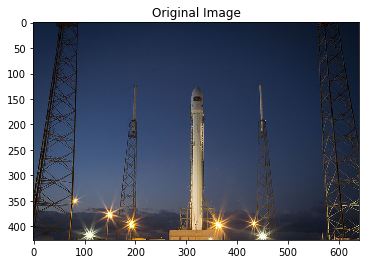

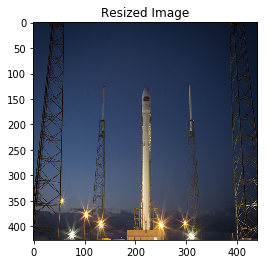

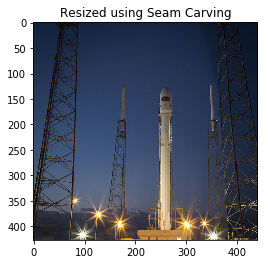

In [3]:
from skimage import data, draw
from skimage import transform, util
from skimage import filters, color
from matplotlib import pyplot as plt

hl_color = np.array([0, 1, 0])

img = data.rocket()
img = util.img_as_float(img)
eimg = filters.sobel(color.rgb2gray(img))

resized = transform.resize(img, (img.shape[0], img.shape[1] - 200),
                           mode='reflect')

seam_carve = transform.seam_carve(img, eimg, 'vertical', 200)

plt.figure()
plt.title('Original Image')
plt.imshow(img)
plt.show()
plt.title('Resized Image')
plt.imshow(resized)
plt.show()
plt.title('Resized using Seam Carving')
plt.imshow(seam_carve)
plt.show()

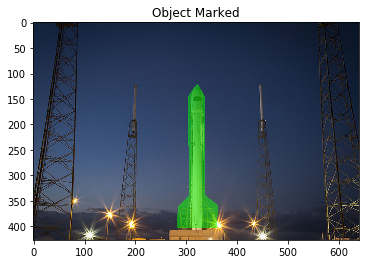

In [4]:
masked_img = img.copy()

poly = [(404, 281), (404, 360), (359, 364), (338, 337), (145, 337), (120, 322),
        (145, 304), (340, 306), (362, 284)]
pr = np.array([p[0] for p in poly])
pc = np.array([p[1] for p in poly])
rr, cc = draw.polygon(pr, pc)

masked_img[rr, cc, :] = masked_img[rr, cc, :]*0.5 + hl_color*.5
plt.figure()
plt.title('Object Marked')
plt.imshow(masked_img)
plt.show()

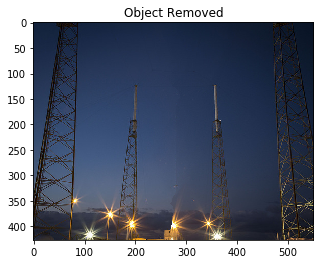

In [5]:
eimg[rr, cc] -= 1000

plt.figure()
plt.title('Object Removed')
obj_carve = transform.seam_carve(img, eimg, 'vertical', 90)
plt.imshow(obj_carve)
plt.show()